In [1]:
import requests
import re
import time
import numpy as np
import pickle
from datetime import timedelta
from crashsimilarity.downloader import SocorroDownloader
from crashsimilarity import utils
from crashsimilarity.distance import DistanceCalculator
from gensim.models import doc2vec
import crashsimilarity.tmp as tmp
import logging

In [ ]:
url1 = 'https://bugzilla.mozilla.org/rest/bug?include_fields=id,summary,status,cf_crash_signature,see_also&f1=cf_crash_signature&f2=see_also&o1=isnotempty&o2=isnotempty&product=Core&product=Firefox'

In [3]:
BASE_URL = 'https://bugzilla.mozilla.org/rest/bug?'
fields = ['id', 'summary', 'status', 'cf_crash_signature', 'see_also']
from_date = '2016-05-31'
to_date = 'Now'
suffix = '&chfield=[Bug creation]&chfieldfrom='+from_date+'&chfieldto='+to_date+'&f2=cf_crash_signature&o2=isnotempty&product=Core&product=Firefox'
url_cf_not_empty_core_firefox_last_year = BASE_URL+'include_fields='+','.join(fields)+suffix

In [5]:
r1 = requests.get(url_cf_not_empty_core_firefox_last_year)
data = r1.json()
bugs = data['bugs']
len(bugs)

In [7]:
see_also = [i for i in bugs if i['see_also'] and any(['bugzilla.mozilla' in s for s in i['see_also']])]
len(see_also)

336

In [10]:
def clean_signatures(sigs):
    sigs = [re.sub(r'\(.*\)', '', s.strip('[] ')) for s in sigs.split('\r\n')]
    sigs = [s[2:] if s.startswith('@ ') else s for s in sigs]
    sigs = [s.strip() for s in sigs]
    return list(set(sigs))
multiple_sig = [i for i in bugs if len(clean_signatures(i['cf_crash_signature'])) > 1]
for sig in multiple_sig:
    sig['clean'] = clean_signatures(sig['cf_crash_signature'])
len(multiple_sig)

267

In [11]:
multiple_sig.sort(key=lambda x: len(x['clean']), reverse=True)

In [29]:
def download_stack_traces(sigs, traces_num=1):
    from_date = utils.utc_today() - timedelta(days=360)
    if isinstance(sigs, str):
        sigs = [sigs]
    params = {'signature': ['^'+i for i in sigs],
              'date': ['>=' + str(from_date)],
              '_facets': ['proto_signature'],
              '_facets_size': traces_num
             }
    _SUPER_SEARCH_URL = 'https://crash-stats.mozilla.com/api/SuperSearch'
    r = requests.get(_SUPER_SEARCH_URL, params)
    return r.json()['facets']['proto_signature']

In [26]:
multiple_sig = [i for i in multiple_sig if len(i['clean']) < 20]

In [69]:
for i in range(len(traces)):
    multiple_sig[i]['prepared'] = groups[i]

In [72]:
# pickle.dump(multiple_sig, open('data/multiple_sig_last_year.pickle', 'wb'))

In [39]:
# traces = []
# t = time.time()
# for i, sig in enumerate(multiple_sig):
#     if i % 20 == 0:
#         print(i, time.time() - t)
#     cur = [download_stack_traces(x) for x in sig['clean']]
#     traces.append(cur)
# print(i, time.time() - t)

0 0.0001933574676513672
20 232.29435515403748
40 376.63871216773987
60 480.8655836582184
80 568.5984752178192
100 649.6185700893402
120 710.3791477680206
140 771.6959414482117
160 834.670690536499
180 897.7750999927521
200 957.2367789745331
220 1018.5516102313995
240 1078.5588011741638
250 1111.7117698192596


In [61]:
# groups = []
# for i, t in enumerate(traces):
#     clean = []
#     for x in t:
#         if x:
#             x = x[0]
#             words = utils.StackTraceProcessor.preprocess(x['term'])
#             if words[0] == '@0x':
#                 words = words[1:]
#             clean.append(words)
#     groups.append(clean)

In [ ]:
# prepared = []
# for group in traces:
#     processed = [utils.StackTraceProcessor.preprocess(i) for i in group]
#     prepared.append(processed)

In [ ]:
# for i, p in enumerate(prepared):
#     multiple_sig[i]['prepared'] = p

In [2]:
vocab = pickle.load(open('data/compressed_vocab.pickle', 'rb'))
len(vocab)

222895

In [3]:
# pickle.dump(multiple_sig, open('data/multiple_sig.pickle', 'wb'))
multiple_sig = pickle.load(open('data/multiple_sig_last_year.pickle', 'rb'))
prepared = [sig['prepared'] for sig in multiple_sig]
len(multiple_sig)

261

In [4]:
groups = []
corpus = []
for p in prepared:
    group = []
    for t in p:
        corpus.append(t)
        group.append(len(corpus)-1)
    groups.append(group)
compressed_corpus = [[str(vocab.get(i, i)) for i in c] for c in corpus]
compressed_corpus = [doc2vec.TaggedDocument(trace, [i]) for i, trace in enumerate(compressed_corpus)]
groups = [g for g in groups if len(g) > 1]

In [14]:
def edit_distance(s1, s2, dist):
    if len(s1) < len(s2):
        return edit_distance(s2, s1, dist)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            d = [dist(s1[i], s2[j]), #insert
                 dist(s2[j], s2[j-1]), #del
                 dist(c1, c2)] #subst
            d = [2 if i < 0 else i for i in d]
            insertions = previous_row[j + 1] + d[0] # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + d[1]      # than s2
            substitutions = previous_row[j] + (c1 != c2) * d[2]
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

In [164]:
groups_with_dist = [(np.average(group_dist(i)),np.average([len(corpus[c]) for c in i]), i) for i in groups]
sort_by_dist = sorted(groups_with_dist, key=lambda x: x[1] / x[0], reverse=True)

/home/kirill/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/kirill/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kirill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


In [165]:
sort_by_dist[:20]

[(0.0, 14.0, [151]),
 (0.0, 6.0, [152, 153, 154, 155]),
 (0.0, 36.0, [402]),
 (0.0, 13.0, [405, 406]),
 (0.0, 25.0, [525]),
 (0.0, 14.0, [528]),
 (0.0, 25.0, [531]),
 (1.1527777777777777, 8.75, [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 (9.1644444444444453,
  35.533333333333331,
  [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 (11.666666666666666, 40.0, [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]),
 (9.0123456790123448,
  25.777777777777779,
  [123, 124, 125, 126, 127, 128, 129, 130, 131]),
 (12.32, 23.399999999999999, [195, 196, 197, 198, 199]),
 (19.930555555555557,
  34.416666666666664,
  [89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]),
 (22.444444444444443, 36.5, [182, 183, 184, 185, 186, 187]),
 (23.346938775510203, 36.714285714285715, [212, 213, 214, 215, 216, 217, 218]),
 (22.722222222222221,
  31.5,
  [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]),
 (24.620000000000001,
  33.700000000000003,
  [55, 56, 57, 58, 59, 60, 61, 62, 63, 64]

In [54]:
def group_dist(group, dist_mat):
    x = np.zeros((len(group), len(group)), dtype=np.float)
    for i, a in enumerate(group):
        for j, b in enumerate(group):
            x[i][j] = dist_mat[a, b]
    return x

In [103]:
edit_dist_mat = edit_distance_matrix(compressed_corpus, edit_distance)

9.999824336430867%, 11.434091806411743 s.
19.999648672861735%, 20.28085708618164 s.
29.999473009292604%, 31.29946756362915 s.
39.99929734572347%, 40.412012815475464 s.
49.99912168215434%, 50.13745069503784 s.
59.99894601858521%, 58.34752535820007 s.
69.99877035501608%, 66.77782106399536 s.
79.99859469144694%, 76.21581983566284 s.
89.99841902787782%, 84.72040176391602 s.
99.99824336430868%, 93.05971121788025 s.


In [8]:
# scores = []
# for group in groups:
#     scores.append(group_score(group, edit_dist_mat))

In [6]:
def edit_distance_matrix(corpus, calculator, prog=10):
    dist = np.zeros((len(corpus), len(corpus)), dtype=np.double)
    idx = []
    for i in range(len(corpus)):
        for j in range(i+1, len(corpus)):
            idx.append((i, j))
    say = len(idx) // prog
    t = time.time()
    for s, (i, j) in enumerate(idx):
        if s and s % say == 0:
            print('{}%, {} s.'.format(s / (len(idx) * 0.01), time.time() - t))
        doc1 = corpus[i].words
        doc2 = corpus[j].words
        dist[i, j] = dist[j, i] = calculator(doc1, doc2)
    return dist

In [7]:
model = doc2vec.Doc2Vec.load('data/model/dm_d200_all.model')
model

INFO:gensim.utils:loading Doc2Vec object from data/model/dm_d200_all.model
INFO:gensim.utils:loading wv recursively from data/model/dm_d200_all.model.wv.* with mmap=None
INFO:gensim.utils:loading syn0 from data/model/dm_d200_all.model.wv.syn0.npy with mmap=None
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:loading docvecs recursively from data/model/dm_d200_all.model.docvecs.* with mmap=None
INFO:gensim.utils:loading doctag_syn0 from data/model/dm_d200_all.model.docvecs.doctag_syn0.npy with mmap=None
INFO:gensim.utils:loading syn1neg from data/model/dm_d200_all.model.syn1neg.npy with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded data/model/dm_d200_all.model


In [52]:
group_5_and_more = [g for g in groups if len(g) >= 5]
len(group_5_and_more)

26

In [8]:
dist, w2pos =  DistanceCalculator.words_distance(compressed_corpus, model)
distance_calculator = DistanceCalculator(model, w2pos, dist)
pos2w = dict([(i[1], i[0]) for i in w2pos.items()])
pos2vocab = dict([(i[1], i[0]) for i in vocab.items()])

INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


len(words) = 2808


In [9]:
my_edit_distance(compressed_corpus[0].words, compressed_corpus[42].words)

NameError: name 'my_edit_distance' is not defined

In [15]:
def my_edit_distance(s1, s2):
    return edit_distance(s1, s2, distance_calculator.compressed_words_dist)
edit_dist_coff = edit_distance_matrix(compressed_corpus, my_edit_distance)

9.999824336430867%, 276.3983690738678 s.
19.999648672861735%, 479.3484363555908 s.
29.999473009292604%, 721.350652217865 s.
39.99929734572347%, 945.0965888500214 s.
49.99912168215434%, 1179.1764607429504 s.
59.99894601858521%, 1381.7647356987 s.
69.99877035501608%, 1590.889322757721 s.
79.99859469144694%, 1828.4149420261383 s.
89.99841902787782%, 2035.4698460102081 s.
99.99824336430868%, 2242.823565006256 s.


In [29]:
def _no_coff_dist(s1, s2):
    return edit_distance(s1, s2, lambda a,b: 1)
# edit_dist_no_coff = edit_distance_matrix(compressed_corpus, _no_coff_dist)
edit_dist_no_coff = pickle.load(open('data/edit_dist_no_coff_last_year.pickle', 'rb'))

In [28]:
# pickle.dump(edit_dist_no_coff, open('data/edit_dist_no_coff_last_year.pickle', 'wb'))

In [27]:
# pickle.dump(edit_dist_coff, open('data/edit_dist_coff_last_year.pickle', 'wb'))

In [40]:
def wmd_mat(corpus, calculator, prog=10):
    wmd_dist = np.zeros((len(corpus), len(corpus)), dtype=np.double)
    idx = []
    for i in range(len(corpus)):
        for j in range(i+1, len(corpus)):
            idx.append((i, j))
    say = len(idx) // prog
    t = time.time()
    for s, (i, j) in enumerate(idx):
        if s and s % say == 0:
            print('{}%, {} s.'.format(s / (len(idx) * 0.01), time.time() - t))
        doc1 = corpus[i].words
        doc2 = corpus[j].words
        wmd_dist[i, j] = wmd_dist[j, i] = calculator.fast_wmd(doc1, doc2)
    return wmd_dist

In [130]:
# wmd_all = wmd_mat(compressed_corpus, distance_calculator, 50)
# pickle.dump(wmd_all, open('data/wmd_all.pickle', 'wb'))
wmd_all = pickle.load(open('data/wmd_all.pickle', 'rb'))

In [131]:
wmd_all[wmd_all == np.inf] = -1
m = np.max(wmd_all)
wmd_all[wmd_all == -1] = m

In [132]:
wmd_all.shape

(1051, 1051)

In [106]:
from sklearn.cluster import DBSCAN
db = DBSCAN(metric='precomputed').fit(edit_dist_mat)

In [107]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

db = DBSCAN(metric='precomputed').fit(edit_dist_mat)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)


Estimated number of clusters: 3


In [162]:
cluster = np.argwhere(db.labels_==0)
cluster = cluster.flatten()
wmd_all[cluster[0], cluster[42]], wmd_all[cluster[13], cluster[42]], wmd_all[cluster[0], cluster[13]]

(1.4533113241195679, 1.4192333221435547, 1.3977205753326416)

In [163]:
corpus[cluster[0]]

['nscomptr_base::assign_from_qi']

In [168]:
long_traces = [c for c in corpus if len(c) > 4]
len(long_traces)

818

In [165]:
corpus[cluster[90]]

['nsstyletransformmatrix::readtransforms']

In [153]:
from collections import Counter
x = [i for i in list(db.labels_) if i != -1]
Counter(x)

Counter({0: 145,
         1: 9,
         2: 27,
         3: 7,
         4: 12,
         5: 9,
         6: 6,
         7: 6,
         8: 5,
         9: 10,
         10: 6,
         11: 5,
         12: 11,
         13: 7,
         14: 5,
         15: 5,
         16: 5,
         17: 9,
         18: 9,
         19: 5,
         20: 5})

In [141]:
db.core_sample_indices_

array([  18,   47,   60,   63,   67,   75,   76,   80,   88,   90,  119,
        120,  140,  143,  144,  154,  169,  188,  217,  228,  244,  285,
        287,  293,  303,  304,  305,  308,  317,  324,  326,  343,  344,
        348,  352,  360,  363,  370,  381,  384,  390,  391,  392,  398,
        404,  406,  411,  414,  426,  430,  440,  442,  445,  446,  455,
        468,  470,  471,  488,  489,  499,  501,  511,  523,  528,  530,
        531,  533,  534,  535,  536,  551,  552,  553,  554,  555,  559,
        567,  574,  579,  580,  581,  585,  589,  598,  602,  629,  637,
        638,  643,  644,  652,  677,  681,  685,  696,  697,  698,  701,
        704,  705,  706,  707,  708,  709,  720,  741,  757,  759,  766,
        767,  773,  775,  777,  782,  787,  807,  808,  811,  820,  821,
        822,  825,  833,  836,  845,  865,  868,  873,  876,  878,  882,
        888,  891,  892,  894,  896,  898,  899,  900,  903,  922,  923,
        927,  930,  941,  948,  951,  961,  962,  9

/home/kirill/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


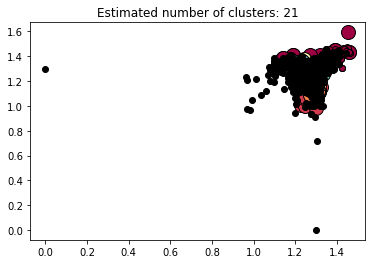

In [135]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = wmd_all[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = wmd_all[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [22]:
def group_score(group, dist):
    closest = [[x[0] for x in sorted(enumerate(dist[i]), key=lambda x:x[1])] for i in group]
    score = []
    for i, c in enumerate(closest):
        others = [x for x in group if x != group[i]]
        pos = [c.index(o) for o in others]
        score.append((np.mean(pos), np.max(pos)))
    return score

In [21]:
groups[0]

[0, 1, 2, 3, 4, 5]

In [31]:
scores_no_coff = []
for group in groups:
    scores_no_coff.append(group_score(group, edit_dist_no_coff))

In [43]:
corpus[706]

['mozilla::layers::dxgitexturehostd3d11::getdevice',
 'mozilla::layers::dxgitexturehostd3d11::lockinternal',
 'mozilla::gfx::vrdisplayhost::submitframe',
 'mozilla::gfx::vrmanager::submitframe',
 'mozilla::gfx::vrlayerparent::recvsubmitframe',
 'mozilla::gfx::pvrlayerparent::onmessagereceived',
 'mozilla::gfx::pvrmanagerparent::onmessagereceived',
 'mozilla::ipc::messagechannel::dispatchasyncmessage',
 'mozilla::ipc::messagechannel::dispatchmessagew',
 'mozilla::ipc::messagechannel::runmessage',
 'mozilla::ipc::messagechannel::messagetask::run',
 'messageloop::runtask',
 'messageloop::deferorrunpendingtask',
 'messageloop::dowork',
 'base::messagepumpforui::dorunloop',
 'base::messagepumpwin::run',
 'messageloop::runhandler',
 'messageloop::run',
 'base::thread::threadmain',
 "`anonymous namespace'::threadfunc",
 'basethreadinitthunk',
 'rtluserthreadstart']

In [42]:
corpus[705]

['mozilla::layers::dxgiycbcrtexturehostd3d11::getdevice',
 'mozilla::layers::dxgitexturehostd3d11::lockinternal',
 'mozilla::gfx::vrdisplayhost::submitframe',
 'mozilla::gfx::vrmanager::submitframe',
 'mozilla::gfx::vrlayerparent::recvsubmitframe',
 'mozilla::gfx::pvrlayerparent::onmessagereceived',
 'mozilla::gfx::pvrmanagerparent::onmessagereceived',
 'mozilla::ipc::messagechannel::dispatchasyncmessage',
 'mozilla::ipc::messagechannel::dispatchmessagew',
 'mozilla::ipc::messagechannel::runmessage',
 'mozilla::ipc::messagechannel::messagetask::run',
 'messageloop::runtask',
 'messageloop::deferorrunpendingtask',
 'messageloop::dowork',
 'base::messagepumpforui::dorunloop',
 'base::messagepumpwin::run',
 'messageloop::runhandler',
 'messageloop::run',
 'base::thread::threadmain',
 "`anonymous namespace'::threadfunc",
 'basethreadinitthunk',
 'rtluserthreadstart']

In [41]:
groups[200]

[705, 706]

In [30]:
edit_dist_no_coff[705, 77]

40.0

In [19]:
x_co

[(705, 0.0),
 (706, 1.0820066928863525),
 (721, 7.1238025426864624),
 (423, 10.841357886791229),
 (720, 12.221334636211395),
 (426, 12.614270925521851),
 (425, 15.082615077495575),
 (560, 15.395968064665794),
 (702, 15.770150452852249),
 (230, 16.24800980091095),
 (236, 16.24800980091095),
 (740, 16.318815022706985),
 (714, 16.325929820537567),
 (715, 16.325929820537567),
 (227, 16.572196245193481),
 (233, 16.572196245193481),
 (107, 17.306257426738739),
 (225, 17.316359102725983),
 (231, 17.316359102725983),
 (725, 17.582080960273743),
 (724, 18.102490544319153),
 (240, 19.391111820936203),
 (739, 19.848719105124474),
 (34, 19.857996910810471),
 (72, 20.292174339294434),
 (526, 20.292174339294434),
 (701, 20.755557268857956),
 (422, 20.848806992173195),
 (654, 20.962189972400665),
 (600, 21.664913356304169),
 (67, 21.973966538906097),
 (527, 21.973966538906097),
 (201, 22.0),
 (202, 22.0),
 (205, 22.0),
 (206, 22.0),
 (239, 22.0),
 (299, 22.0),
 (300, 22.0),
 (329, 22.0),
 (349, 22.0)

In [23]:
x_co = sorted(enumerate(edit_dist_coff[705]), key=lambda x:x[1])
x_co[:10]

[(705, 0.0),
 (706, 1.0820066928863525),
 (721, 7.1238025426864624),
 (423, 10.841357886791229),
 (720, 12.221334636211395),
 (426, 12.614270925521851),
 (425, 15.082615077495575),
 (560, 15.395968064665794),
 (702, 15.770150452852249),
 (230, 16.24800980091095)]

In [46]:
x_no_co = sorted(enumerate(edit_dist_no_coff[705]), key=lambda x:x[1])
x_no_co[:10]

[(705, 0.0),
 (706, 1.0),
 (721, 7.0),
 (423, 10.0),
 (426, 11.0),
 (720, 12.0),
 (560, 13.0),
 (702, 13.0),
 (724, 13.0),
 (725, 13.0)]

In [36]:
list(enumerate(scores_no_coff))

[(0,
  [(210.59999999999999, 606),
   (410.80000000000001, 541),
   (213.19999999999999, 537),
   (303.0, 533),
   (205.59999999999999, 609),
   (9.0, 15)]),
 (1,
  [(7.5, 14),
   (7.4285714285714288, 14),
   (478.28571428571428, 521),
   (468.07142857142856, 510),
   (7.3571428571428568, 14),
   (7.5, 14),
   (7.2857142857142856, 14),
   (7.2142857142857144, 14),
   (7.1428571428571432, 14),
   (7.0714285714285712, 14),
   (7.4285714285714288, 14),
   (7.0, 14),
   (7.3571428571428568, 14),
   (6.9285714285714288, 14),
   (7.2857142857142856, 14)]),
 (2,
  [(257.09090909090907, 624),
   (30.727272727272727, 51),
   (46.454545454545453, 90),
   (37.090909090909093, 84),
   (380.27272727272725, 587),
   (30.272727272727273, 58),
   (327.09090909090907, 587),
   (446.36363636363637, 606),
   (73.545454545454547, 113),
   (385.18181818181819, 604),
   (378.72727272727275, 590),
   (26.90909090909091, 46)]),
 (3,
  [(84.555555555555557, 462),
   (61.777777777777779, 214),
   (167.777777777

In [32]:
scores_coff = []
for group in groups:
    scores_coff.append(group_score(group, edit_dist_coff))

In [67]:
st = compressed_corpus[groups[70][0]].words
distance_calculator.compressed_words_dist(st[2], st[3]), distance_calculator.compressed_words_dist(st[3], st[4])

(1.582178, 1.5107409)

In [70]:
xxx  = sorted(enumerate(edit_dist_coff[groups[70][0]]), key=lambda x:x[1])
xxx[:10]

[(403, 0.0),
 (648, 3.3931815028190613),
 (660, 3.3931815028190613),
 (440, 3.4005177021026611),
 (455, 4.033565491437912),
 (454, 4.0385113656520844),
 (441, 4.4005177021026611),
 (456, 5.033565491437912),
 (397, 7.917635440826416),
 (649, 8.565386950969696)]

In [93]:
sim = model.wv.most_similar(compressed_corpus[403].words[-5])
[pos2vocab[int(i[0])] for i in sim]

['base::linearhistogram::factoryget',
 'getprocesspriorityboost',
 'mozilla::bootstrapimpl::xre_initchildprocess',
 'base::histogram::sampleset::accumulate',
 'k32getmoduleinformationstub',
 'sdp_set_owner_sessionid',
 'uhash_close_55',
 'cmpegvideoprop::videodialogproc',
 'libcertcheckcertificatehygiene',
 'filebearsmarkoftheweb']

In [1]:
compressed_corpus[403].words[-5]

NameError: name 'compressed_corpus' is not defined

In [82]:
pos2vocab[2726]

'mozilla::d3d9dxva2manager::init'

In [78]:
st1 = corpus[397]
st2 = st1
st2[0] = 
edit_dist_coff[397, 403], edit_dist_no_coff[397, 403]

(7.917635440826416, 6.0)

In [74]:
corpus[397]

['mozilla::a11y::docaccessibleparent::recvmsaaid',
 'mozilla::a11y::pdocaccessibleparent::onmessagereceived',
 'mozilla::dom::pcontentparent::onmessagereceived',
 'mozilla::ipc::messagechannel::dispatchasyncmessage',
 'mozilla::ipc::messagechannel::dispatchmessagew',
 'mozilla::ipc::messagechannel::onmaybedequeueone',
 'mozilla::detail::runnablemethodimpl<t>::run',
 'mozilla::ipc::messagechannel::dequeuetask::run',
 'nsthread::processnextevent',
 'mozilla::ipc::messagepump::run',
 'messageloop::runhandler',
 'messageloop::run',
 'nsbaseappshell::run',
 'nsappshell::run',
 'nsappstartup::run',
 'xremain::xre_mainrun',
 'xremain::xre_main',
 'xre_main',
 'do_main',
 'wmain',
 '__scrt_common_main_seh',
 'basethreadinitthunk',
 'rtluserthreadstart']

In [75]:
corpus[403]

['mozilla::ipc::fatalerror',
 'mozilla::a11y::pdocaccessibleparent::onmessagereceived',
 'mozilla::dom::pcontentparent::onmessagereceived',
 'mozilla::ipc::messagechannel::dispatchasyncmessage',
 'mozilla::ipc::messagechannel::dispatchmessagew',
 'mozilla::ipc::messagechannel::runmessage',
 'mozilla::ipc::messagechannel::messagetask::run',
 'nsthread::processnextevent',
 'mozilla::ipc::messagepump::run',
 'messageloop::runhandler',
 'messageloop::run',
 'nsbaseappshell::run',
 'nsappshell::run',
 'nsappstartup::run',
 'xremain::xre_mainrun',
 'xremain::xre_main',
 'mozilla::bootstrapimpl::xre_main',
 'ns_internal_main',
 'wmain',
 '__scrt_common_main_seh',
 'basethreadinitthunk',
 'rtluserthreadstart']

In [37]:
list(enumerate(scores_coff))

[(0,
  [(184.19999999999999, 575),
   (261.60000000000002, 543),
   (212.0, 533),
   (220.80000000000001, 561),
   (185.0, 583),
   (213.0, 540)]),
 (1,
  [(7.5, 14),
   (7.4285714285714288, 14),
   (431.85714285714283, 471),
   (411.5, 456),
   (7.3571428571428568, 14),
   (7.5, 14),
   (7.2857142857142856, 14),
   (7.2142857142857144, 14),
   (7.1428571428571432, 14),
   (7.0714285714285712, 14),
   (7.4285714285714288, 14),
   (7.0, 14),
   (7.3571428571428568, 14),
   (6.9285714285714288, 14),
   (7.2857142857142856, 14)]),
 (2,
  [(290.18181818181819, 597),
   (136.0, 448),
   (120.0, 472),
   (161.81818181818181, 460),
   (406.09090909090907, 714),
   (155.81818181818181, 453),
   (301.81818181818181, 622),
   (378.54545454545456, 589),
   (222.54545454545453, 484),
   (345.09090909090907, 582),
   (377.63636363636363, 626),
   (230.90909090909091, 466)]),
 (3,
  [(88.444444444444443, 445),
   (50.888888888888886, 168),
   (122.0, 505),
   (84.222222222222229, 411),
   (102.11111

In [47]:
edit_dist_no_coff[groups[5][5], groups[5][0]]

31.0

In [57]:
group_dist(groups[5], edit_dist_no_coff)[0]

array([  0.,  31.,  31.,  36.,  28.,  31.,  28.,  31.,  28.,  31.])

In [58]:
group_dist(groups[5], edit_dist_coff)[0]

array([  0.        ,  33.37286228,  38.71433285,  47.27805412,
        36.20078218,  34.66117102,  34.56650436,  33.59761113,
        35.85789943,  30.71762544])

In [51]:
edit_dist_coff[groups[5][5]]


array([ 52.70696092,  41.17193735,  41.65851724,  41.97689366,
        52.10872817,  35.32200879,  48.19659567,  48.19659567,
        41.31118453,  42.24538065,  48.19659567,  48.3113544 ,
        48.19659567,  48.19659567,  48.19659567,  48.19659567,
        48.3113544 ,  48.19659567,  48.3113544 ,  48.19659567,
        48.3113544 ,  34.66117102,  45.18863028,  28.52014011,
        31.81839079,  17.78045142,  34.99709117,  20.45093381,
        42.14386785,  46.95585424,  43.17442429,  41.12287574,
        47.14800915,  41.86997581,  47.52182174,  41.70254409,
        42.82147229,  41.97952855,  41.96060604,  46.83314916,
        41.97952855,  40.62980103,  41.91887951,  43.07189885,
        43.7237896 ,  43.7237896 ,  42.99223596,  43.7237896 ,
        43.7237896 ,  43.7237896 ,  43.15226692,  43.7237896 ,
        43.7237896 ,  43.7237896 ,  43.7237896 ,  34.66117102,
        22.70004776,  34.7504425 ,  48.27107418,  18.69962126,
         0.        ,  20.45093381,  11.40219256,  16.74

In [48]:
edit_dist_coff[groups[5][5], groups[5][0]]

34.661171019077301

In [40]:
corpus[groups[5][5]]

['igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'ccontext::id3d11devicecontext1_setshaderresources_<t>',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'ccontext::id3d11devicecontext1_setsamplers_<t>',
 'igd10umd64.dll@0x',
 'chwshaderstate::sendstate',
 'igd10umd64.dll@0x',
 'ccontext::id3d11devicecontext1_draw_<t>',
 'cd3ddevicelevel1::drawdynamicvb',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'ntdll.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'ccontext::umquerycs_constbuf_',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'igd10umd64.dll@0x',
 'ccontext::id3d11devicecontext1_updatesubresource_<t>',
 'igd10umd64.dll@0x',
 'ccontext::id3d11devicecontext1_rssetscissorrects_<t>',
 'd3dlargesurface::d3dlargesurface',
 'ccontext::id3d11devicecontext1_discardresource_<t

In [34]:
# clear_scores = []
# for group in clear_groups:
#     clear_scores.append(group_score(group, wmd_all))

In [35]:
# list(enumerate(clear_scores))

In [197]:
tmp.lcs(corpus[cg[9][0]], corpus[cg[9][8]])

[('defaultfreeentry', 3, 2),
 ('pl_hashtabledestroy', 4, 3),
 ('secoid_shutdown', 5, 4),
 ('nss_shutdown', 6, 5),
 ('nss_shutdown', 7, 6),
 ('nsnsscomponent::shutdownnss', 8, 7),
 ('nsnsscomponent::observe', 10, 9),
 ('nsobserverservice::notifyobservers', 12, 10),
 ('nsxredirprovider::doshutdown', 13, 11),
 ('scopedxpcomstartup::~scopedxpcomstartup', 14, 12),
 ('xremain::xre_main', 15, 13),
 ('xre_main', 16, 14)]

In [93]:
def clear_groups(groups):
    rv = []
    for g in groups:
        cg = [i for i in g if len(corpus[i]) > 3]
        avg = np.average([len(corpus[i]) for i in cg])
        cg = [i for i in cg if len(corpus[i]) > avg/2]
        rv.append(cg)
    return rv

In [177]:
cg = clear_groups(group_5_and_more)
cg[2]

[228, 232]